In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import nbinom
import time
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import copy
import scipy
import pickle

from scipy.stats import poisson

In [2]:
lw = 3
erates_plot_multiplier = 6
# Parameters
gamma = 0.2  # Recovery rate
mean_beta = 2 * gamma  # Mean transmission rate
amplitude = 0  # Amplitude of seasonal forcing
delta = 1/365  # Immune waning rate
sigma = 0.8
sigma_c = 0.55
mu = 1

In [3]:
def get_em_rate(mu=1e-4, beta=1, gamma=0.5, S=0.9, R=0.05, I=0.05, sigma=0.4, sigma_c=0, mu_ex=0):
    # mu_ex is 'mutation rate' due to importation of cases!
    # sigma_c is cross-immunity
    poisson_mu = beta*(S + (1-sigma_c) * R)/gamma

    #z = np.arange(poisson.ppf(0.0001, poisson_mu), poisson.ppf(0.9999, poisson_mu))
    #Pz = poisson.pmf(z, poisson_mu)
    #d = get_extinction_prob_from_zdist(Pz)
    if poisson_mu>1:
        d = 1/poisson_mu
    else:
        d=1

    em_rate = (I * mu * beta * (S + (1-sigma) * R) + mu_ex)* (1-d)
    #print("Emergence rate:", em_rate)
    eff_susc_resid = (R * (1-sigma) + S)
    one_minus_d = (1-d)
    return em_rate, one_minus_d, eff_susc_resid

def get_em_rate_twostrain(mu, beta, gamma, S, I1, I2, I12, I21, R1, R2, R, sigma, sigma_c, mu_ex):
    # mu_ex is 'mutation rate' due to importation of cases!
    poisson_mu = beta * ((1-sigma_c) * (R1 + R2 + R) + S)/gamma
    
    #z = np.arange(poisson.ppf(0.0001, poisson_mu), poisson.ppf(0.9999, poisson_mu))
    #Pz = poisson.pmf(z, poisson_mu)
    #d = get_extinction_prob_from_zdist(Pz)
    if poisson_mu>1:
        d = 1/poisson_mu
    else:
        d=1
    
    em_rate = ((I1 + I12) * mu * beta * (S + (1-sigma)*(R1+R) + (1-sigma_c) * R2) + \
               (I2 + I21) * mu * beta * (S + (1-sigma)*(R2+R) + (1-sigma_c) * R1) + mu_ex)* (1-d)
    
    # (Weighted) effective susceptibles seen by an infected with strain 1 or 2
    eff_susc_resid = S + ((I1+I12)/(I1+I2+I12+I21)) * ((1-sigma_c) * R2 + (1-sigma)*(R1+R)) + \
                     ((I2+I21)/(I1+I2+I12+I21)) * ((1-sigma_c) * R1 + (1-sigma)*(R2+R))
    one_minus_d = 1-d
    
    return em_rate, one_minus_d, eff_susc_resid

# Fig 5A:

In [4]:
mu_ex = 0.01 * mu

N = 1000  # Total population
I0 = 1  # Initial number of infected individuals
S0 = N*2/10 - I0  # Initial number of susceptible individuals
R0 = 8*N/10  # Initial number of recovered individuals
T = 300  # Total time (1 year)
dt = 0.2  # Time step (1 day)

# Initialize arrays
times = np.arange(0, T+dt, dt)
S = np.zeros(len(times))
I = np.zeros(len(times))
R = np.zeros(len(times))
betas = np.zeros(len(times))

mu_exs = np.ones(len(times))
mu_exs *= mu_ex # 0, 5e-6, 1e-5

# Set initial conditions
S[0] = S0
I[0] = I0
R[0] = R0
beta_t = mean_beta + amplitude * np.cos(2 * np.pi * 0 / 365)  # Seasonal forcing of beta
betas[0] = beta_t

# Euler's method for numerical integration
for t in range(1, len(times)):
    beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[t] / 365)  # Seasonal forcing of beta
    # Introducing NPIs:
    if times[t] >= 50:
        beta_t *= 0.8
        mu_ex = 0
    betas[t] = beta_t
    mu_exs[t] = mu_ex
    S[t] = S[t-1] + dt * (-beta_t * S[t-1] * I[t-1] / N + delta * R[t-1])
    I[t] = I[t-1] + dt * (beta_t * S[t-1] * I[t-1] / N + beta_t * (1-sigma) * R[t-1] * I[t-1] / N - gamma * I[t-1])
    R[t] = R[t-1] + dt * (gamma * I[t-1] - delta * R[t-1] - beta_t * (1-sigma) * R[t-1] * I[t-1] / N)

# Given the parameters, compute the emergence rate for each timestep:
erates = np.zeros(len(times))
omds = np.zeros(len(times))
eSrs = np.zeros(len(times))
for t in range(len(times)):
    beta_t = betas[t]
    er, omd, eSr = get_em_rate(mu=mu, beta=beta_t, gamma=gamma, S=S[t]/N, R=R[t]/N, I=I[t]/N,
                               sigma=sigma, sigma_c=sigma_c, mu_ex=mu_exs[t])
    erates[t] = er
    omds[t] = omd
    eSrs[t] = eSr

# For plotting the results
sigma_upscaled = int(sigma * 100)
sigma_c_upscaled = int(sigma_c * 100)


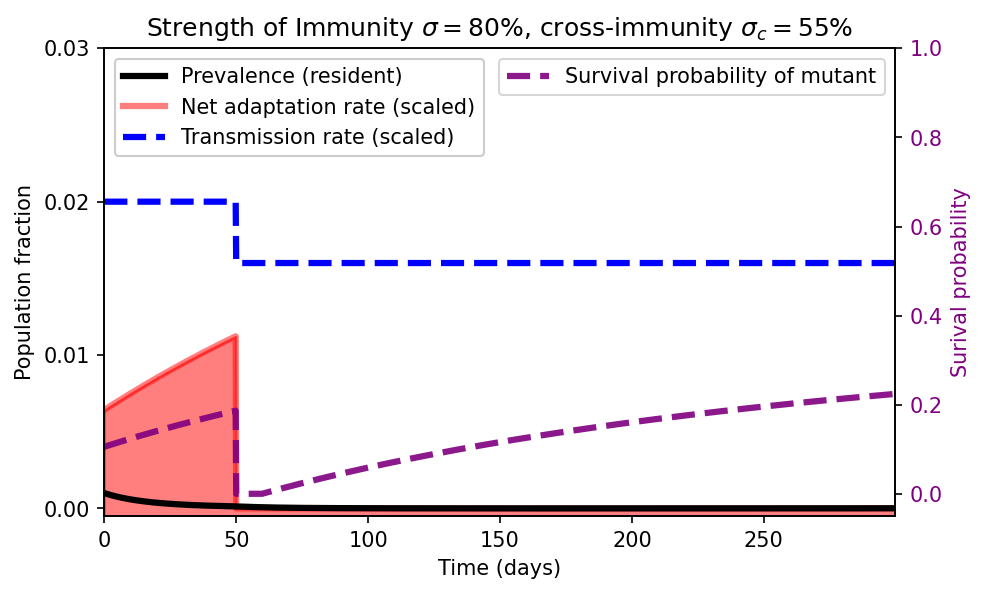

Max emergence rate: 0.001869935909650506


In [5]:
plt.figure(figsize=(1.62 * 4.2, 1.62 * 2.5), dpi=150)

ax1 = plt.gca()

imin = 0
imax = -1

Iplotvar = I[imin:imax]/N

plt.plot(times[imin:imax], Iplotvar, label='Prevalence (resident)', color='black', linewidth=lw)

plt.plot(times[imin:imax], erates_plot_multiplier * erates[imin:imax], label='Net adaptation rate (scaled)', color="red", linewidth=lw, zorder=0, alpha=0.5)
ax1.fill_between(times[imin:imax], erates_plot_multiplier * erates[imin:imax], -0.002, color='red', alpha=.5)
#plt.plot(times, 1000*eSrs, '--', label='Effective susceptibles (resident) (scaled)', color="orange", linewidth=lw)
plt.plot(times[imin:imax], 0.05*betas[imin:imax], '--', label='Transmission rate (scaled)', color="blue", linewidth=lw, zorder=0)

ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population fraction')
#ax1.set_ylim([-0.015,np.max(Iplotvar)*2 ])
ax1.set_ylim([-0.05/100, 3/100])
ax1.set_yticks([0, 0.01, 0.02, 0.03])

ax2 = ax1.twinx()
ax2.set_ylabel('Surival probability', color="purple")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim([-0.05,1])
ax2.plot(times[imin:imax], omds[imin:imax], '--', label='Survival probability of mutant', color="purple", linewidth=lw, alpha=0.9, zorder=1)
#ax2.fill_between(times[imin:imax], omds[imin:imax], 0, color='purple', alpha=.1)

ax1.set_xlim([0,np.max(times[imin:imax])])
ax2.set_xlim([0,np.max(times[imin:imax])])

#plt.ylim([0,N])
plt.title(r'Strength of Immunity $\sigma=$' + f'{sigma_upscaled}%, cross-immunity ' + r'$\sigma_c=$' + f'{sigma_c_upscaled}%')
leg = ax1.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
frame = leg.get_frame()
#frame.set_color('white')
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.7)
leg.set_zorder(102)
leg.remove()

frame.set_alpha(1)
ax2.legend(loc='upper right')
ax2.add_artist(leg)
#plt.savefig(pngdir + "single.png", dpi=150)
plt.show()
print("Max emergence rate:", np.max(erates))

In [6]:
# Fig 5B:

In [7]:
mu_ex = 0.01 * mu

N = 1000  # Total population
I0 = 1  # Initial number of infected individuals
S0 = N*2/10 - I0  # Initial number of susceptible individuals
R0 = 8*N/10  # Initial number of recovered individuals
T = 300  # Total time (1 year)
dt = 0.2  # Time step (1 day)

# Initialize arrays
times = np.arange(0, T+dt, dt)
S = np.zeros(len(times))
I = np.zeros(len(times))
R = np.zeros(len(times))
betas = np.zeros(len(times))

mu_exs = np.ones(len(times))
mu_exs *= mu_ex # 0, 5e-6, 1e-5

# Set initial conditions
S[0] = S0
I[0] = I0
R[0] = R0
beta_t = mean_beta + amplitude * np.cos(2 * np.pi * 0 / 365)  # Seasonal forcing of beta
betas[0] = beta_t

# Euler's method for numerical integration
for t in range(1, len(times)):
    beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[t] / 365)  # Seasonal forcing of beta
    # Introducing NPIs:
    if times[t] >= 50:
        beta_t *= 0.8
    betas[t] = beta_t
    mu_exs[t] = mu_ex
    S[t] = S[t-1] + dt * (-beta_t * S[t-1] * I[t-1] / N + delta * R[t-1])
    I[t] = I[t-1] + dt * (beta_t * S[t-1] * I[t-1] / N + beta_t * (1-sigma) * R[t-1] * I[t-1] / N - gamma * I[t-1])
    R[t] = R[t-1] + dt * (gamma * I[t-1] - delta * R[t-1] - beta_t * (1-sigma) * R[t-1] * I[t-1] / N)

# Given the parameters, compute the emergence rate for each timestep:
erates = np.zeros(len(times))
omds = np.zeros(len(times))
eSrs = np.zeros(len(times))
for t in range(len(times)):
    beta_t = betas[t]
    er, omd, eSr = get_em_rate(mu=mu, beta=beta_t, gamma=gamma, S=S[t]/N, R=R[t]/N, I=I[t]/N,
                               sigma=sigma, sigma_c=sigma_c, mu_ex=mu_exs[t])
    erates[t] = er
    omds[t] = omd
    eSrs[t] = eSr

# For plotting the results
sigma_upscaled = int(sigma * 100)
sigma_c_upscaled = int(sigma_c * 100)


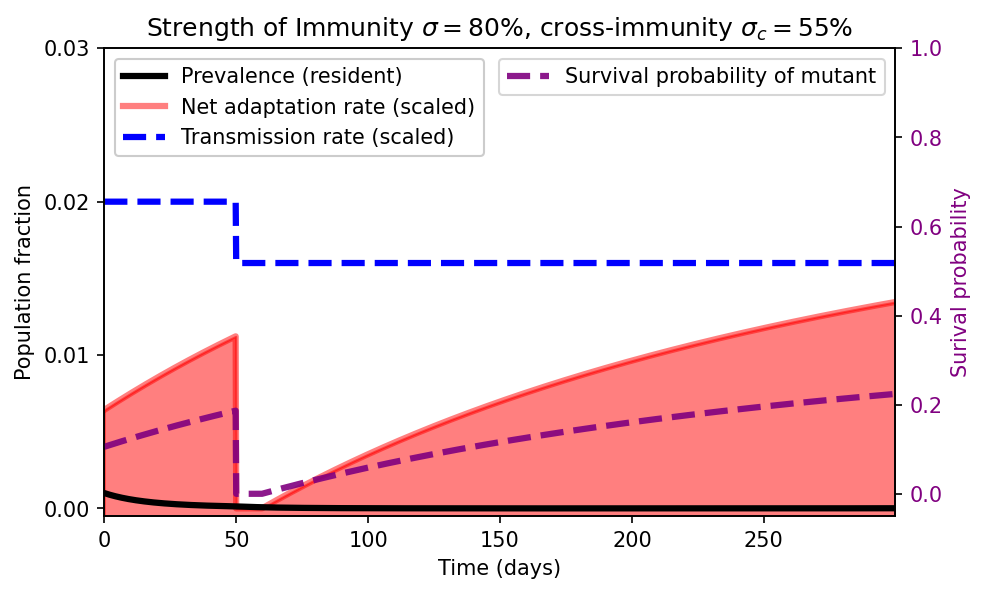

Max emergence rate: 0.002244034842737281


In [8]:
plt.figure(figsize=(1.62 * 4.2, 1.62 * 2.5), dpi=150)

ax1 = plt.gca()

imin = 0
imax = -1

Iplotvar = I[imin:imax]/N

plt.plot(times[imin:imax], Iplotvar, label='Prevalence (resident)', color='black', linewidth=lw)

plt.plot(times[imin:imax], erates_plot_multiplier * erates[imin:imax], label='Net adaptation rate (scaled)', color="red", linewidth=lw, zorder=0, alpha=0.5)
ax1.fill_between(times[imin:imax], erates_plot_multiplier * erates[imin:imax], -0.002, color='red', alpha=.5)
#plt.plot(times, 1000*eSrs, '--', label='Effective susceptibles (resident) (scaled)', color="orange", linewidth=lw)
plt.plot(times[imin:imax], 0.05*betas[imin:imax], '--', label='Transmission rate (scaled)', color="blue", linewidth=lw, zorder=0)

ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population fraction')
#ax1.set_ylim([-0.015,np.max(Iplotvar)*2 ])
ax1.set_ylim([-0.05/100, 3/100])
ax1.set_yticks([0, 0.01, 0.02, 0.03])

ax2 = ax1.twinx()
ax2.set_ylabel('Surival probability', color="purple")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim([-0.05,1])
ax2.plot(times[imin:imax], omds[imin:imax], '--', label='Survival probability of mutant', color="purple", linewidth=lw, alpha=0.9, zorder=1)
#ax2.fill_between(times[imin:imax], omds[imin:imax], 0, color='purple', alpha=.1)

ax1.set_xlim([0,np.max(times[imin:imax])])
ax2.set_xlim([0,np.max(times[imin:imax])])

#plt.ylim([0,N])
plt.title(r'Strength of Immunity $\sigma=$' + f'{sigma_upscaled}%, cross-immunity ' + r'$\sigma_c=$' + f'{sigma_c_upscaled}%')
leg = ax1.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
frame = leg.get_frame()
#frame.set_color('white')
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.7)
leg.set_zorder(102)
leg.remove()

frame.set_alpha(1)
ax2.legend(loc='upper right')
ax2.add_artist(leg)
#plt.savefig(pngdir + "single.png", dpi=150)
plt.show()
print("Max emergence rate:", np.max(erates))